In [17]:
import os
import math
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import time
import yaml
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from policy_finetune.scripts.simulate_detection import DetectionSimulator
import sys
sys.path.append('../scripts')
from tensordict import MemoryMappedTensor, TensorDict

from actor_utils import ActorNet
from utils import *
from evasion_guidance.scripts.evasion_risk import EvasionRisk

## Load the trained model. ##

In [18]:
checkpoints_path = "/home/yixuany/workspace/CORL/output"
run_name = "BC-evasion-v2-multimodal-fdfb354f"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint_1550000.pt"))
# model_dict = torch.load(os.path.join(checkpoints_path, "checkpoint_1550000.pt"))

In [19]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [20]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
if config['env']['observation']['goal_direction_normalized']:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-1, 1, shape=(2,))})
else:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-map_size / 2.0, map_size / 2.0, shape=(2,))})


In [21]:
model_dict

{'actor': OrderedDict([('log_std',
               tensor([-45.3093, -45.2956], device='cuda:0')),
              ('feature_extractor.extractors.heat_map.cnn.0.weight',
               tensor([[[[ 0.0747, -0.1291,  0.0404,  ...,  0.0344,  0.0381, -0.1536],
                         [ 0.0270, -0.0054, -0.0531,  ..., -0.0305, -0.0377,  0.0511],
                         [-0.1030,  0.0728, -0.0011,  ..., -0.0038, -0.1225, -0.1153],
                         ...,
                         [-0.0774,  0.0956, -0.0209,  ..., -0.0061,  0.0085, -0.0671],
                         [-0.0773, -0.0443, -0.1239,  ...,  0.0783,  0.1015, -0.0949],
                         [-0.1225, -0.1462, -0.0704,  ...,  0.0731, -0.1135,  0.1129]]],
               
               
                       [[[-0.0999,  0.1033,  0.0636,  ...,  0.0822,  0.0285, -0.0442],
                         [-0.1117, -0.0042,  0.1194,  ...,  0.0839, -0.0729,  0.1006],
                         [-0.1403, -0.1498, -0.0817,  ..., -0.0396, -0.00

### Load Actor ###

In [22]:
assert config['policy']['hidden_act'] == 'Tanh' or config['policy']['hidden_act'] == 'ReLU', "Currently only support ReLU or Tanh."
if config['policy']['hidden_act'] == 'Tanh':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.Tanh)
if config['policy']['hidden_act'] == 'ReLU':
    print("Using ReLU.")
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.ReLU)
actor.load_state_dict(model_dict['actor'])
actor.eval()

Using ReLU.


ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=258, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (action_net): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Tanh()
  )
)

### Load one of the training data ###

In [23]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = config['env']['action_max']

In [24]:
map_size

1000

In [25]:
# episode_idx = 250

In [38]:
episode_idx = 0
data_path = "/home/yixuany/workspace/CORL/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']
# goal_location = [1000.0, -100.0]

### Simulator for shutdown process
shutdown_simulator = DetectionSimulator(radar_locs, radar_radius, 12, 3)

risk_evaluator = EvasionRisk(radar_locs, 0, 100)
time_spent = 0
time_spent_heat_map = 0
total_risk = 0
trajectory = [state_cur]
q_values = []
start = time.time()
with torch.no_grad():
    while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
        # if time_spent % 10 == 0:
        #     print("Time spent: ", time_spent)
        if time_spent > config['env']['max_time_step']:
            print("Reached time limit.")
            break
        hm_start = time.time()
        heat_map = get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size)
        hm_end = time.time()
        time_spent_heat_map += hm_end - hm_start
        goal_direction = center_state(state_cur, goal_location) / (map_size / 2.0)
        
        obs = TensorDict({
            'heat_map': torch.from_numpy(heat_map).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy(goal_direction).unsqueeze(dim=0).float()
        })

        u, distribution = actor(obs)
        log_prob = distribution.distribution.log_prob(u).squeeze().cpu().detach().numpy()
        u = u.squeeze().cpu().detach().numpy()
        u = action_rescaling*(u[np.argmax(log_prob)])
        total_risk += risk_evaluator.evalute_risk(state_cur, u)
        if shutdown_simulator.update_shutdown(state_cur, u):
            print("Shutdown")
            # break
        state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u/V])
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
end = time.time()
# expert_risk = 0
# for i in range(episode_dict['input_history'].shape[0]):
#     expert_risk += risk_evaluator.evalute_risk(episode_dict['state_history'][i, :], episode_dict['input_history'][0])
# print('Expert risk: ', expert_risk)
# print("Total time steps: ", time_spent)
print("Total Time: ", end - start)
# print("Time spent on heat map", time_spent_heat_map)
print("Length of trajectory: ", len(trajectory))
print("Total Risk: ", total_risk)
trajectory = np.asarray(trajectory)

Shutdown
Shutdown
Shutdown
Shutdown
Reached time limit.
Total Time:  0.6534509658813477
Length of trajectory:  102
Total Risk:  40.25224790610118


### Visualize the trajectory generated by student policy. ###

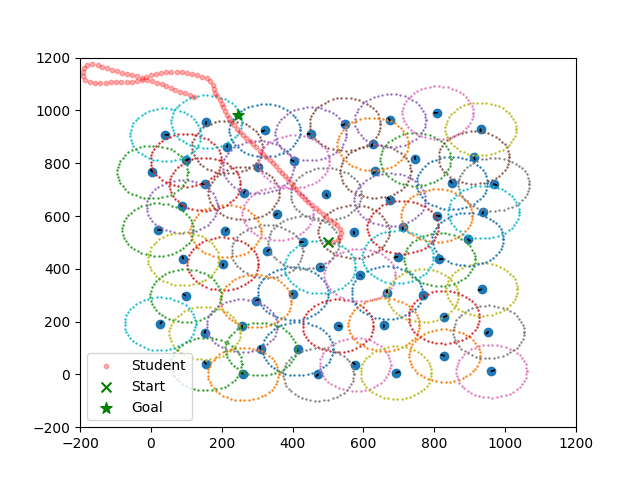

In [39]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r', alpha=0.3, label='Student')
# ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g', alpha=0.3, label='Expert')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()

## For Debugging: Visualize Heat maps. Visualize the collected training trajectories. ##

In [28]:
# img_size = 100
# radar_radius = 100
# aircraft_detection_range=100
# grid_size=2*aircraft_detection_range/img_size
# heat_map = get_radar_heat_map(episode_dict['start_state'], radar_locs, img_size, aircraft_detection_range, grid_size, radar_radius)

# plt.close()
# plt.imshow(heat_map.squeeze(), cmap='hot', interpolation='nearest', origin="lower")
# plt.show()   

In [29]:
# plt.close()
# fig, ax = plt.subplots()
# visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])
for i in range(1000):
    episode_idx = i
    episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()
    
    if math.hypot(episode_dict['goal_location'][0] - goal_location[0], episode_dict['goal_location'][1] - goal_location[1]) < 5.0:
        print("Exists similar goal: ",episode_dict['goal_location'] )
    # ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=1, c='g', alpha=0.3)
    # ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x')
    # ax.scatter(episode_dict['goal_location'][0], episode_dict['goal_location'][1], s=50, c='g', marker='*')

# ax.set_xlim(-200, 1.2*map_size)
# ax.set_ylim(-200, 1.2*map_size)
# # ax.legend()
# plt.show()

Exists similar goal:  [192.42360357 235.44453394]
